# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146456 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 18.5MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Thu Feb  4 01:03:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/Data/nlp'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'nsmc', 'quora', 'songys']

In [7]:
# songys chatbot dir
songys_dir = os.path.join(data_dir, 'songys')
if not os.path.exists(songys_dir):
    os.makedirs(songys_dir)
os.listdir(songys_dir)

[]

# 모델링

In [8]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '네가 기분이 좋으니 나도 좋아'],
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [9]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 6,
  '나는': 4,
  '나도': 10,
  '네가': 8,
  '오늘': 5,
  '좋아': 7,
  '좋으니': 9,
  '행복하다': 12,
  '행복해': 11},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '기분이',
  7: '좋아',
  8: '네가',
  9: '좋으니',
  10: '나도',
  11: '행복해',
  12: '행복하다'})

In [10]:
# Question과 Answer를 숫자료
question_list, answer_list = [], []

for pair in sentences:
  question_list.append([word_to_id[word] for word in pair[0].split()])
  answer_list.append([word_to_id[word] for word in pair[1].split()])
question_list, answer_list

([[4, 5, 6, 7], [4, 5, 11]], [[8, 6, 9, 10, 7], [10, 12]])

In [11]:
# 학습용 입력 데이터 생성
train_enc_inputs, train_dec_inputs, train_labels = [], [], []

for question, answer in zip(question_list, answer_list):
  train_enc_inputs.append(question)
  train_dec_inputs.append([word_to_id['[BOS]']] +answer)
  train_labels.append(answer + [word_to_id['[EOS]']])

train_enc_inputs, train_dec_inputs, train_labels

([[4, 5, 6, 7], [4, 5, 11]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3]])

In [12]:
# Encoder 입력의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
  row += [0] * (4 - len(row))

# Decoder 입력의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_dec_inputs:
  row += [0] * (6 - len(row))

# 정답의 길이를 모두 동일하게 변경 (최대길이 6)
for row in train_labels:
  row += [0] * (6 - len(row))

train_enc_inputs, train_dec_inputs, train_labels

([[4, 5, 6, 7], [4, 5, 11, 0]],
 [[2, 8, 6, 9, 10, 7], [2, 10, 12, 0, 0, 0]],
 [[8, 6, 9, 10, 7, 3], [10, 12, 3, 0, 0, 0]])

In [13]:
# numpy array로 변환/
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_labels = np.array(train_labels)

train_enc_inputs, train_dec_inputs, train_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  6,  9, 10,  7],
        [ 2, 10, 12,  0,  0,  0]]), array([[ 8,  6,  9, 10,  7,  3],
        [10, 12,  3,  0,  0,  0]]))

In [14]:
# embedding 생성
embedding = tf.keras.layers.Embedding(len(id_to_word), 5)
# word embedding
hidden_enc = embedding(train_enc_inputs)  # (bs, n_enc_seq, 5)
hidden_dec = embedding(train_dec_inputs)  # (bs, n_dec_seq, 5)
hidden_enc.shape, hidden_dec.shape

(TensorShape([2, 4, 5]), TensorShape([2, 6, 5]))

In [15]:
# Encoder LSTM (uni-direction, bi-direction 가능)
fw_cell = tf.keras.layers.LSTM(units=4, return_state=True)
bw_cell = tf.keras.layers.LSTM(units=4, go_backwards=True, return_state=True)

lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)

hidden_enc.shape, fw_h.shape, fw_c.shape, bw_h.shape, bw_c.shape

(TensorShape([2, 8]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]))

In [16]:
# Concat hidden and cell state
s_h = K.concatenate([fw_h, bw_h], axis = -1)
s_c = K.concatenate([fw_c, bw_c], axis = -1)
s_h.shape, s_c.shape

(TensorShape([2, 8]), TensorShape([2, 8]))

In [17]:
# Decoder LSTM (uni-direction만 가능)
lstm_dec = tf.keras.layers.LSTM(units = 8, return_sequences= True)
hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])
hidden_dec.shape

TensorShape([2, 6, 8])

In [18]:
# Decoder 입력의 다음단어 예측
dense_out = tf.keras.layers.Dense(units = len(id_to_word), activation = tf.nn.softmax)
outputs = dense_out(hidden_dec)
outputs.shape

TensorShape([2, 6, 13])

In [21]:
def build_model(n_vocab, d_model, n_enc_seq, n_dec_seq):
    """
    seq2seq 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_enc_seq: encoder 문장 길이 (단어 수)
    :param n_dec_seq: decoder 문장 길이 (단어 수)
    """
    inputs_enc = tf.keras.layers.Input((n_enc_seq,))  # (bs, n_enc_seq)
    inputs_dec = tf.keras.layers.Input((n_dec_seq,))  # (bs, n_dec_seq)
    ################################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_enc = embedding(inputs_enc)  # (bs, n_enc_seq, d_model)
    hidden_dec = embedding(inputs_dec)  # (bs, n_dec_seq, d_model)

    # Encoder LSTM (uni-direction, bi-direction 가능)
    fw_cell = tf.keras.layers.LSTM(units=d_model, return_state=True)
    bw_cell = tf.keras.layers.LSTM(units=d_model, go_backwards=True, return_state=True)
    lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
    hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)

    # Concatenate hidden states and cell states
    s_h = K.concatenate([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
    s_c = K.concatenate([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)

    # Decoder LSTM (uni-direction만 가능)
    lstm_dec = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)
    
    # 다음단어 예측
    dense_out = tf.keras.layers.Dense(units=n_vocab, activation=tf.nn.softmax)
    outputs = dense_out(hidden_dec)  # (bs, n_dec_seq, n_vocab)
    ################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_enc, inputs_dec), outputs=outputs)
    return model

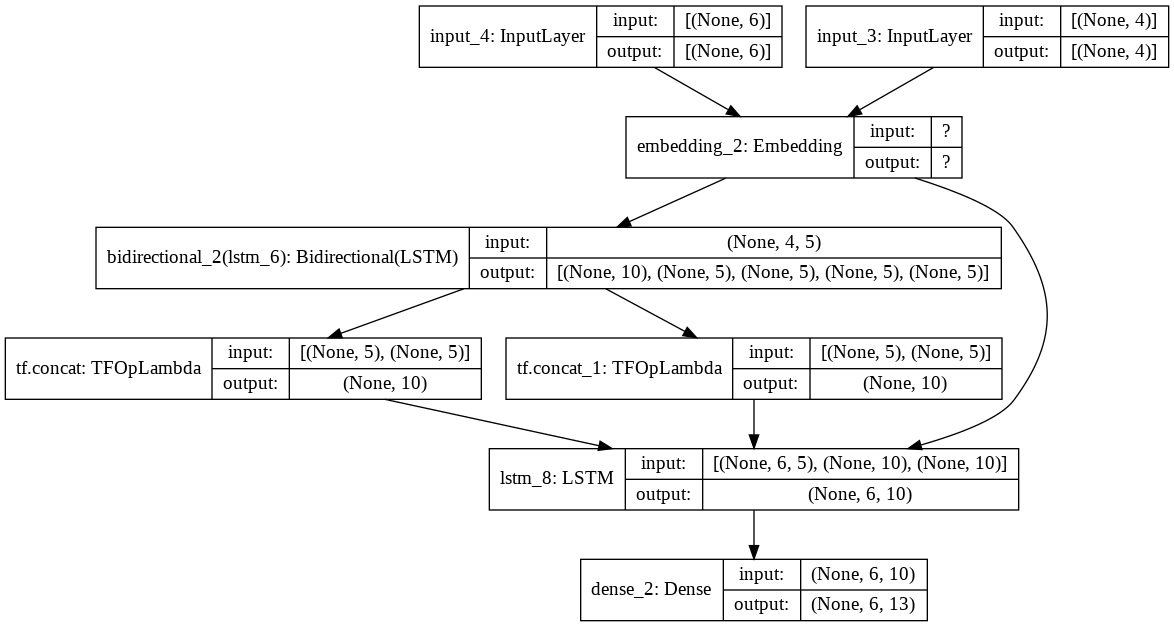

In [22]:
# 모델 생성
model = build_model(len(id_to_word), 5, 4, 6)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# 다운로드
- https://github.com/songys/Chatbot_data

In [23]:
# 파일 다운로드 및 목록 확인
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
os.listdir('./')

--2021-02-04 01:09:52--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-02-04 01:09:52--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv’

ChatbotData .csv    100%[===================>] 868.99K  --.-KB/s    in 0.02s   

2021-02-04 01:09:52 (42.3 MB/s) - ‘ChatbotData .csv’ saved [889842/889842]



['.config', 'drive', 'model.png', 'ChatbotData .csv', 'sample_data']

In [24]:
# 파일명 변경 및 목록 확인
!mv 'ChatbotData .csv' ChatbotData.csv
os.listdir('./')

['.config', 'drive', 'model.png', 'ChatbotData.csv', 'sample_data']

In [25]:
# 파일 이동
shutil.move('ChatbotData.csv', os.path.join(songys_dir, 'ChatbotData.csv'))
os.listdir(songys_dir)

['ChatbotData.csv']

# Vocabulary & config

In [26]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [27]:
n_vocab = len(vocab)  # number of vocabulary
n_enc_seq = 32  # number of sequence 1
n_dec_seq = 40  # number of sequence 2
d_model = 256  # dimension of model

# 데이터 분석

In [28]:
# train data load
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'), delimiter=',')
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [29]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


## Char

### Q

In [30]:
# char 길이 데이터
char_len = df_train['Q'].astype("str").apply(len)
char_len.head(10)

0     6
1    11
2    12
3    15
4     7
5     9
6     7
7    14
8    23
9    17
Name: Q, dtype: int64

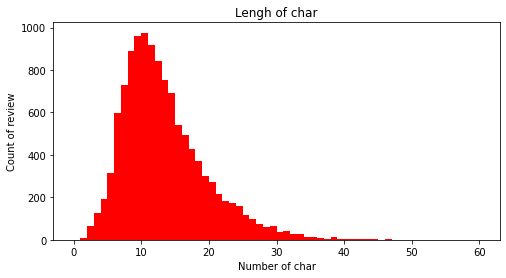

In [31]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=60, range=[0, 60], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [32]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:      56
char 길이 최소:       1
char 길이 평균:      12.88
char 길이 표준편차:    6.17
char 25/100분위:     9.00
char 50/100분위:    12.00
char 75/100분위:    16.00
char IQR:           7.00
char MAX/100분위:   26.50


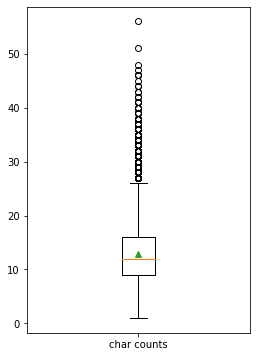

In [33]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

### A

In [34]:
# char 길이 데이터
char_len = df_train['A'].astype("str").apply(len)
char_len.head(10)

0    10
1     9
2    11
3    11
4    10
5    18
6    18
7    16
8    13
9    13
Name: A, dtype: int64

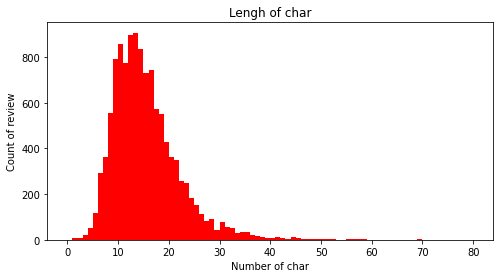

In [35]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=80, range=[0, 80], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [36]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:      76
char 길이 최소:       1
char 길이 평균:      15.02
char 길이 표준편차:    6.70
char 25/100분위:    10.00
char 50/100분위:    14.00
char 75/100분위:    18.00
char IQR:           8.00
char MAX/100분위:   30.00


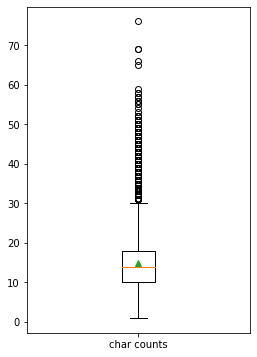

In [37]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

## Word

### Q

In [38]:
# word 길이 데이터
word_len = df_train['Q'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0    2
1    3
2    3
3    4
4    2
5    2
6    2
7    4
8    7
9    4
Name: Q, dtype: int64

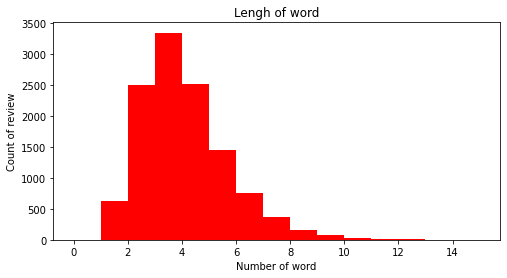

In [39]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=15, range=[0, 15], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [40]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      15
word 길이 최소:       1
word 길이 평균:       3.59
word 길이 표준편차:    1.62
word 25/100분위:     2.00
word 50/100분위:     3.00
word 75/100분위:     4.00
word IQR:           2.00
word MAX/100분위:    7.00


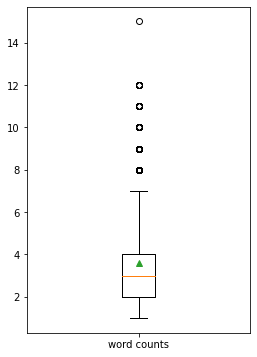

In [41]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

### A

In [42]:
# word 길이 데이터
word_len = df_train['A'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0    3
1    2
2    3
3    3
4    2
5    6
6    6
7    5
8    3
9    3
Name: A, dtype: int64

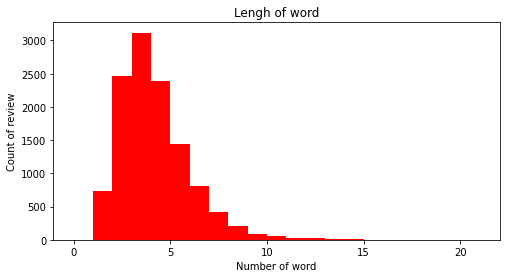

In [43]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=21, range=[0, 21], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [44]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      21
word 길이 최소:       1
word 길이 평균:       3.69
word 길이 표준편차:    1.86
word 25/100분위:     2.00
word 50/100분위:     3.00
word 75/100분위:     5.00
word IQR:           3.00
word MAX/100분위:    9.50


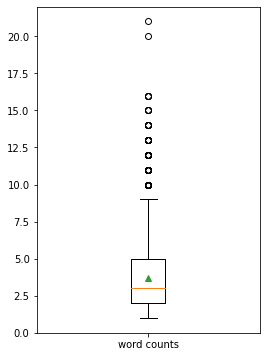

In [45]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

## SentencePiece

### Q

In [46]:
# word 길이 데이터
spm_len = df_train['Q'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

0     5
1     6
2     9
3    10
4     5
5     6
6     4
7     7
8    11
9     9
Name: Q, dtype: int64

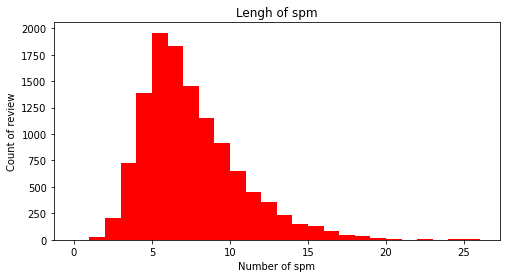

In [47]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=26, range=[0, 26], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [48]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:      26
spm 길이 최소:       1
spm 길이 평균:       7.00
spm 길이 표준편차:    3.09
spm 25/100분위:     5.00
spm 50/100분위:     6.00
spm 75/100분위:     9.00
spm IQR:           4.00
spm MAX/100분위:   15.00


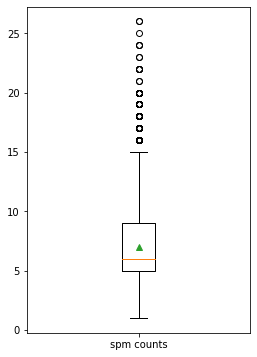

In [49]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

### A

In [50]:
# word 길이 데이터
spm_len = df_train['A'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

0    6
1    6
2    6
3    6
4    8
5    9
6    9
7    7
8    6
9    6
Name: A, dtype: int64

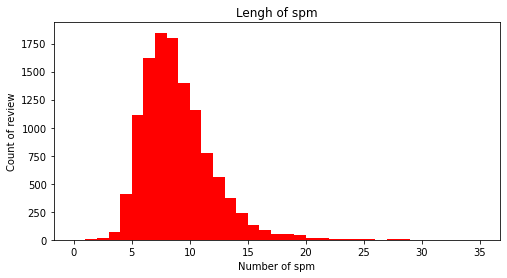

In [51]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=35, range=[0, 35], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [52]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:      35
spm 길이 최소:       1
spm 길이 평균:       8.44
spm 길이 표준편차:    3.06
spm 25/100분위:     6.00
spm 50/100분위:     8.00
spm 75/100분위:    10.00
spm IQR:           4.00
spm MAX/100분위:   16.00


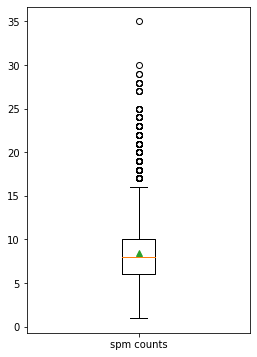

In [53]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

## Word Cloud

In [54]:
# data 합치기
train_set = pd.Series(df_train['Q'].tolist() + df_train['A'].tolist()).astype(str)
train_set.head(10)

0                     12시 땡!
1                1지망 학교 떨어졌어
2               3박4일 놀러가고 싶다
3            3박4일 정도 놀러가고 싶다
4                    PPL 심하네
5                  SD카드 망가졌어
6                    SD카드 안돼
7             SNS 맞팔 왜 안하지ㅠㅠ
8    SNS 시간낭비인 거 아는데 매일 하는 중
9          SNS 시간낭비인데 자꾸 보게됨
dtype: object

In [55]:
# train review documents
train_review = [review for review in train_set if type(review) is str]
train_review[:10]

['12시 땡!',
 '1지망 학교 떨어졌어',
 '3박4일 놀러가고 싶다',
 '3박4일 정도 놀러가고 싶다',
 'PPL 심하네',
 'SD카드 망가졌어',
 'SD카드 안돼',
 'SNS 맞팔 왜 안하지ㅠㅠ',
 'SNS 시간낭비인 거 아는데 매일 하는 중',
 'SNS 시간낭비인데 자꾸 보게됨']

In [56]:
' '.join(train_review[:10])

'12시 땡! 1지망 학교 떨어졌어 3박4일 놀러가고 싶다 3박4일 정도 놀러가고 싶다 PPL 심하네 SD카드 망가졌어 SD카드 안돼 SNS 맞팔 왜 안하지ㅠㅠ SNS 시간낭비인 거 아는데 매일 하는 중 SNS 시간낭비인데 자꾸 보게됨'

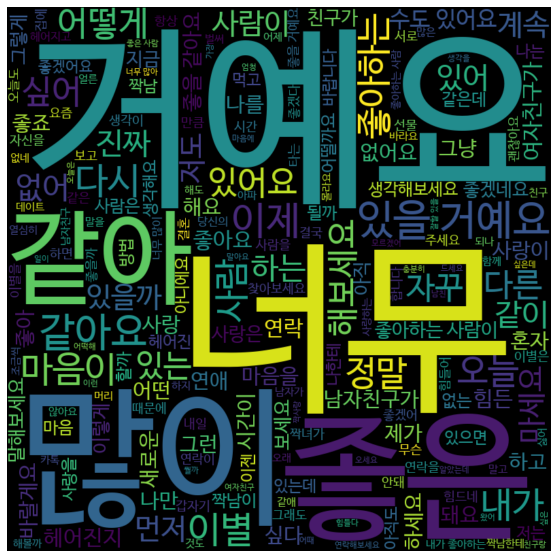

In [57]:
# WordCloud
# window: C:/Windows/Fonts/malgun.ttf, mac: /Library/Fonts/AppleGothic.ttf, colab: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(10, 10))
# https://datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Loss & Acc

In [58]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [59]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Sample Data Project

## Data


In [60]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [61]:
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [62]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,Q,A,label
11761,하루종일 썸남 생각만 해. 괜찮을까?,그것 또한 감정의 일부니까요.,2
924,냉장고에 먹을 게 하나도 없네,슈퍼라도 가서 쇼핑하고 오세요.,0
3763,인사드리러 갔는데 파혼하는게 나을것 같아,이혼이 아니라 다행입니다.,0
341,금값 어때,비싸요.,0
10736,연애상담하더니 둘이 사귀더라,대화를 하다가 친해졌나봐요.,2
5140,혼자 노래방 가면 어색할 거 같은데,신나는 노래로 분위기를 띄어보세요.,0
5713,기회도 없네.,다른 기회가 올 거예요.,1
9996,사랑한 만큼 배려해야했어,이제야 깨달았나봐요.,2
3168,여자친구가 전화를 안해,다른 연락을 많이 하거나 더 자주 만나세요.,0
9762,못생긴 남자를 좋아하는 여자가 있을지.,외모가 중요한 시대는 끝났어요.,2


In [69]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        print()
        ###########################################
        Q = row['Q']
        A = row['A']
        print(Q, '/', A)

        tokens_q = vocab.encode_as_pieces(Q)
        print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_pieces(A)
        print(len(tokens_a), ':', tokens_a)

        tokens_ids_q = vocab.encode_as_ids(Q)[:n_enc_max]
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = vocab.encode_as_ids(A)[:n_enc_max]
        print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q +=[0] * (n_enc_seq - len(tokens_ids_q))
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        print(len(tokens_dec_in), ':', tokens_dec_in)
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))
        print(len(tokens_dec_out), ':', tokens_dec_out)

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
        ###########################################
    return enc_inputs, dec_inputs, labels

In [70]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels


하루종일 썸남 생각만 해. 괜찮을까? / 그것 또한 감정의 일부니까요.
14 : ['▁하루', '종', '일', '▁', '썸', '남', '▁생각', '만', '▁해', '.', '▁괜찮', '을', '까', '?']
8 : ['▁그것', '▁또한', '▁감정', '의', '▁일부', '니까', '요', '.']
14 : [2261, 389, 26, 10, 28134, 481, 1162, 62, 210, 7, 22827, 16, 2657, 1860]
8 : [8223, 109, 3971, 9, 396, 8933, 431, 7]
32 : [2261, 389, 26, 10, 28134, 481, 1162, 62, 210, 7, 22827, 16, 2657, 1860, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 : [2, 8223, 109, 3971, 9, 396, 8933, 431, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 : [8223, 109, 3971, 9, 396, 8933, 431, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

냉장고에 먹을 게 하나도 없네 / 슈퍼라도 가서 쇼핑하고 오세요.
10 : ['▁냉', '장', '고', '에', '▁먹을', '▁게', '▁하나', '도', '▁없', '네']
8 : ['▁슈퍼', '라도', '▁가서', '▁쇼핑', '하고', '▁오', '세요', '.']
10 : [8255, 147, 37, 13, 12600, 1513, 925, 32, 6943, 343]
8 : [2505, 4743, 3424, 15489, 43, 178, 15319, 7]
32 : [8255, 147, 37, 13

(array([[ 2261,   389,    26,    10, 28134,   481,  1162,    62,   210,
             7, 22827,    16,  2657,  1860,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 8255,   147,    37,    13, 12600,  1513,   925,    32,  6943,
           343,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 3299,  5537,   447,    10, 19191,   437,  1980,    42,   128,
           339,    16,  5922, 15509,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  631,  4167,   492,  1406,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
 

## 학습

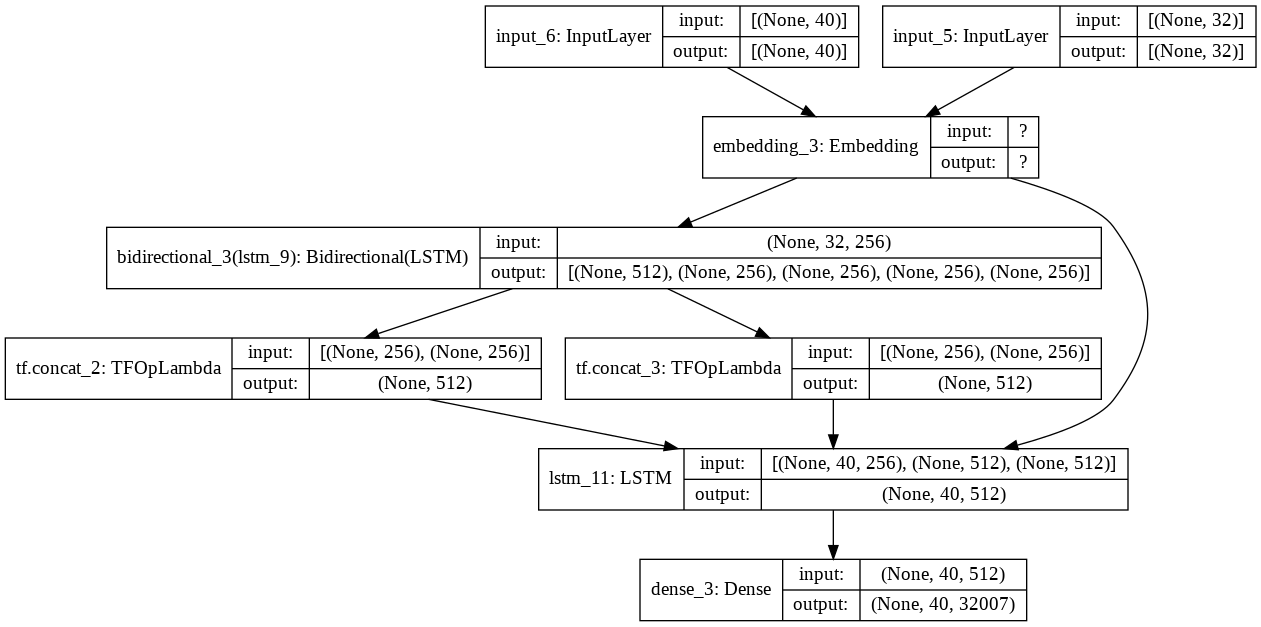

In [71]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [72]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [73]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm.csv'))

In [74]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=400,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/400
1/1 [==============================] - 4s 4s/step - loss: 2.2822 - lm_acc: 0.0000e+00

Epoch 00001: lm_acc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/Data/nlp/songys/lstm.hdf5
Epoch 2/400
1/1 [==============================] - 0s 191ms/step - loss: 2.2807 - lm_acc: 0.1477

Epoch 00002: lm_acc improved from 0.00000 to 0.14773, saving model to /content/drive/MyDrive/Data/nlp/songys/lstm.hdf5
Epoch 3/400
1/1 [==============================] - 0s 189ms/step - loss: 2.2787 - lm_acc: 0.1818

Epoch 00003: lm_acc improved from 0.14773 to 0.18182, saving model to /content/drive/MyDrive/Data/nlp/songys/lstm.hdf5
Epoch 4/400
1/1 [==============================] - 0s 132ms/step - loss: 2.2750 - lm_acc: 0.1818

Epoch 00004: lm_acc did not improve from 0.18182
Epoch 5/400
1/1 [==============================] - 0s 124ms/step - loss: 2.2666 - lm_acc: 0.1477

Epoch 00005: lm_acc did not improve from 0.18182
Epoch 6/400
1/1 [==============================] - 0s 119

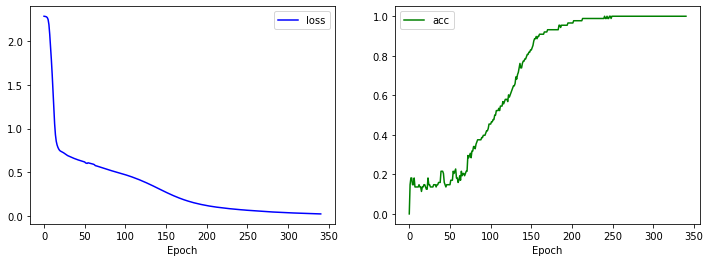

In [75]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm.hdf5'))

In [122]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    #####################################
    # qeustion
    q = vocab.encode_as_pieces(string)
    print(q)
    q_id = vocab.encode_as_ids(string)[:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    #print(len(q_id), q_id)
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    #print(len(a_id), a_id)
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(0,n_dec_seq -1):
      outputs = model.predict((np.array([q_id]), np.array([a_id])))
      # print(outputs.shape)
      prob = outputs[0][start_idx]
      word_id = int(np.argmax(prob))
      # print(prob[word_id - 5:word_id + 5])
      #print(word_id, vocab.id_to_piece(word_id))

      if word_id == vocab.eos_id():
        break
      a_id[start_idx + 1] = word_id
      start_idx += 1
      #print(start_idx, a_id)
      #print()

    predict_id = a_id[1:start_idx + 1]
    #print(predict_id)
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

"""
    # 다음단어 예측
    outputs = model.predict((np.array([q_id]), np.array([a_id])))
    # print(outputs.shape)
    prob = outputs[0][start_idx]
    word_id = int(np.argmax(prob))
    # print(prob[word_id - 5:word_id + 5])
    print(word_id, vocab.id_to_piece(word_id))
    # eos면 종료
    # if word_id == vocab.eos_id():
    #     break
    a_id[start_idx + 1] = word_id
    start_idx += 1
    print(start_idx, a_id)
		# ------

    # 다음단어 예측
    outputs = model.predict((np.array([q_id]), np.array([a_id])))
    # print(outputs.shape)
    prob = outputs[0][start_idx]
    word_id = int(np.argmax(prob))
    # print(prob[word_id - 5:word_id + 5])
    print(word_id, vocab.id_to_piece(word_id))
"""
    #####################################

'\n    # 다음단어 예측\n    outputs = model.predict((np.array([q_id]), np.array([a_id])))\n    # print(outputs.shape)\n    prob = outputs[0][start_idx]\n    word_id = int(np.argmax(prob))\n    # print(prob[word_id - 5:word_id + 5])\n    print(word_id, vocab.id_to_piece(word_id))\n    # eos면 종료\n    # if word_id == vocab.eos_id():\n    #     break\n    a_id[start_idx + 1] = word_id\n    start_idx += 1\n    print(start_idx, a_id)\n\t\t# ------\n\n    # 다음단어 예측\n    outputs = model.predict((np.array([q_id]), np.array([a_id])))\n    # print(outputs.shape)\n    prob = outputs[0][start_idx]\n    word_id = int(np.argmax(prob))\n    # print(prob[word_id - 5:word_id + 5])\n    print(word_id, vocab.id_to_piece(word_id))\n'

In [123]:
string = '너는 누구니'
do_chat(vocab, model, n_enc_seq, n_dec_seq, string)

['▁너', '는', '▁누구', '니']


'다른 기회가 올 거예요.'

In [119]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 너는 누구니
['▁너', '는', '▁누구', '니']
32 [5103, 11, 8214, 213, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
93 ▁다른
1 [2, 93, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

4828 ▁기회
2 [2, 93, 4828, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

19 가
3 [2, 93, 4828, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1793 ▁올
4 [2, 93, 4828, 19, 1793, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1140 ▁거
5 [2, 93, 4828, 19, 1793, 1140, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

625 예
6 [2, 93, 4828, 19, 1793, 1140, 625, 0,

# All Data Project

## Data


In [124]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [125]:
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [126]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        Q = row['Q']
        A = row['A']
        # print(Q, '/', A)

        tokens_q = vocab.encode_as_pieces(Q)
        # print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_pieces(A)
        # print(len(tokens_a), ':', tokens_a)

        tokens_ids_q = vocab.encode_as_ids(Q)
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = vocab.encode_as_ids(A)
        # print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_ids_q = tokens_ids_q[:n_enc_max]
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = tokens_ids_a[:n_dec_max]
        # print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        # print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        # print(len(tokens_dec_in), ':', tokens_dec_in)
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))
        # print(len(tokens_dec_out), ':', tokens_dec_out)

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [127]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

(array([[   89,    56,    10, ...,     0,     0,     0],
        [   35,    47,  1004, ...,     0,     0,     0],
        [   38,   819,   362, ...,     0,     0,     0],
        ...,
        [ 2886,  9525, 21930, ...,     0,     0,     0],
        [10736,  8256,  1172, ...,     0,     0,     0],
        [26128,    70,  1381, ...,     0,     0,     0]], dtype=int32),
 array([[    2,  2261,    19, ...,     0,     0,     0],
        [    2,  4594,    61, ...,     0,     0,     0],
        [    2,  2350,    18, ...,     0,     0,     0],
        ...,
        [    2,  1522,     1, ...,     0,     0,     0],
        [    2,   441, 10316, ...,     0,     0,     0],
        [    2, 16665,    90, ...,     0,     0,     0]], dtype=int32),
 array([[ 2261,    19,   375, ...,     0,     0,     0],
        [ 4594,    61,   929, ...,     0,     0,     0],
        [ 2350,    18,  9001, ...,     0,     0,     0],
        ...,
        [ 1522,     1, 12273, ...,     0,     0,     0],
        [  441, 103

In [128]:
train_enc_inputs.shape, train_dec_inputs.shape, train_labels.shape

((11823, 32), (11823, 40), (11823, 40))

## 학습

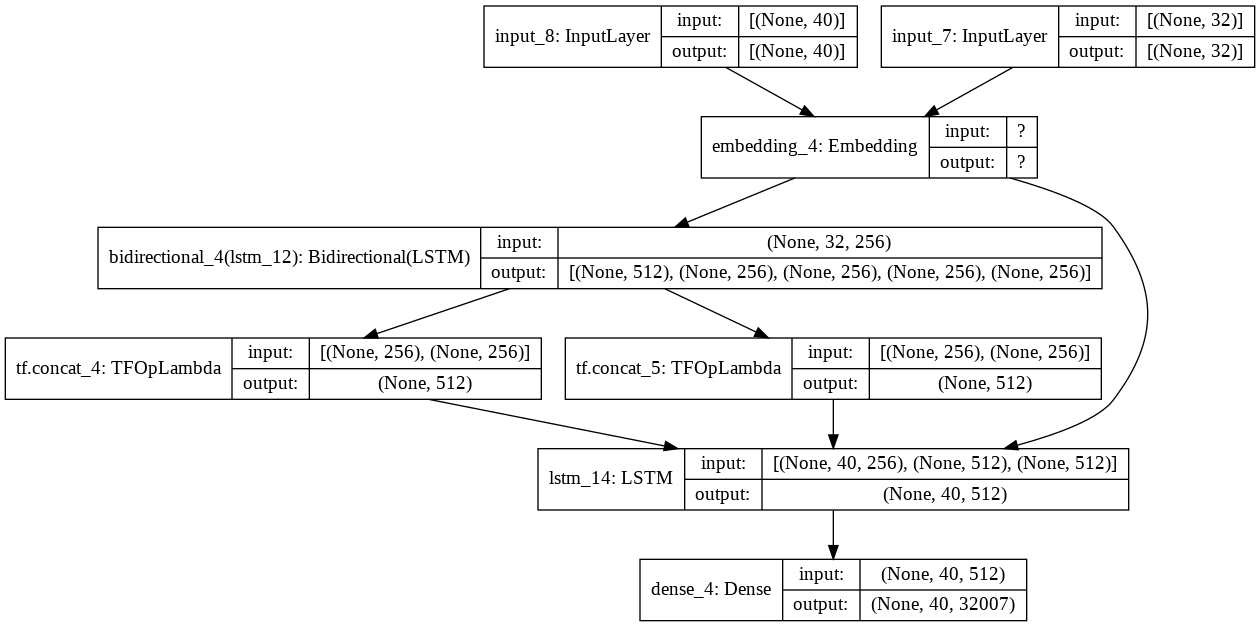

In [129]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [130]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [131]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=10)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm.csv'))

In [132]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
47/47 [==============================] - 27s 501ms/step - loss: 1.9598 - lm_acc: 0.1228

Epoch 00001: lm_acc improved from -inf to 0.11743, saving model to /content/drive/MyDrive/Data/nlp/songys/lstm.hdf5
Epoch 2/100
47/47 [==============================] - 24s 510ms/step - loss: 1.3111 - lm_acc: 0.1245

Epoch 00002: lm_acc improved from 0.11743 to 0.12684, saving model to /content/drive/MyDrive/Data/nlp/songys/lstm.hdf5
Epoch 3/100
47/47 [==============================] - 24s 520ms/step - loss: 1.2814 - lm_acc: 0.1337

Epoch 00003: lm_acc improved from 0.12684 to 0.14037, saving model to /content/drive/MyDrive/Data/nlp/songys/lstm.hdf5
Epoch 4/100
47/47 [==============================] - 25s 531ms/step - loss: 1.2202 - lm_acc: 0.2115

Epoch 00004: lm_acc improved from 0.14037 to 0.24234, saving model to /content/drive/MyDrive/Data/nlp/songys/lstm.hdf5
Epoch 5/100
47/47 [==============================] - 25s 534ms/step - loss: 1.1402 - lm_acc: 0.2766

Epoch 00005: lm_acc im

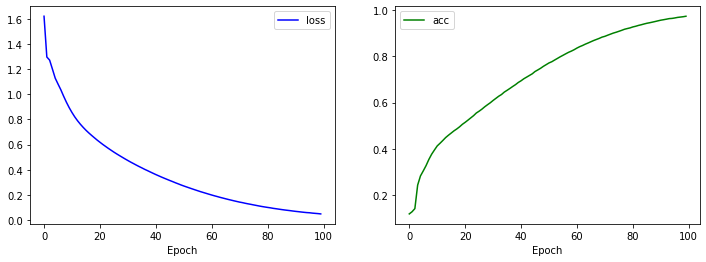

In [133]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [134]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm.hdf5'))

In [135]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [136]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 이름이 무엇입니까
답변 > 아파트가 살기가 좋아요.
질문 > 아파트가 살기가 좋아요
답변 > 아파트가 살기가 좋아요.
질문 > 날씨가 어때요
답변 > 친구가 될 거예요!
질문 > 오늘은 춥네요
답변 > 욕 먹을 짓 하지마세요.
질문 > 식사 하셨나요
답변 > 모르는 게 잘못인 거 같아요.
질문 > 점심 메뉴 추천좀 해주세요
답변 > 맛있을 거 같아요.
질문 > 눈이 오네요
답변 > 냉장고 파먹기 해보세요.
질문 > 피곤해요
답변 > 말하세요.
질문 > 피곤
답변 > 고민이 되시길 바랍니다.
질문 > 피곤하다고
답변 > 고민이 있나봐요.
질문 > 졸려요
답변 > 오늘 일찍 주무세요.
질문 > 못해요
답변 > 행복하게 사세요.
질문 > 바빠요
답변 > 혼자가 있나봐요.
질문 > 바보
답변 > 힘내지 않아도 괜찮아요.
질문 > 
